In [1]:
import sklearn
import pandas as pd
import numpy as np
import random as rd
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Sequential, layers, activations
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

2022-11-03 19:25:00.366437: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-03 19:25:18.265124: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-03 19:25:18.265207: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-03 19:25:19.309346: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-03 19:25:32.641090: W tensorflow/stream_executor/platform/de

In [2]:
main_df =         pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/bikes.csv')
holdout_df =      pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/bikes_december.csv')
mini_holdout_df = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/biking_holdout_test_mini.csv')

In [ ]:
# COLUMNS & DESCRIPTORS

# instant: record index 
# dteday : date 
# season : season (1:winter, 2:spring, 3:summer, 4:fall) 
# hr : hour (0 to 23) 
# holiday : weather day is holiday or not
# workingday : if day is neither weekend nor holiday is 1, otherwise is 0. 
# weathersit : 
# 1: Clear, Few clouds, Partly cloudy, Partly cloudy 
# 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist 
# 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds 
# 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
# temp_c : temperature in Celsius. 
# feels_like_c: "Feels like" temperature in Celsius. 
# hum: humidity percentage
# windspeed: Wind speed.
# casual: count of casual users
# registered: count of registered users

In [121]:
# main_df.describe
main_df.describe().transpose()[['mean', 'std']]

,mean,std
season,2.482058,1.085930
hr,11.547875,6.914199
holiday,0.028671,0.166885
workingday,0.684378,0.464777
weathersit,1.415580,0.637298
hum,0.624756,0.193227
windspeed,12.750436,8.168415
temp_c,15.723008,9.041349
feels_like_c,15.852141,11.322751
casual,36.471239,49.995203


In [7]:
main_df.head()

,dteday,season,hr,holiday,workingday,weathersit,hum,windspeed,temp_c,feels_like_c,casual,registered
0,1/1/11,1,0,0,0,1,0.81,0,3.28,3.0014,3,13
1,1/1/11,1,1,0,0,1,0.80,0,2.34,1.9982,8,32
2,1/1/11,1,2,0,0,1,0.80,0,2.34,1.9982,5,27
3,1/1/11,1,3,0,0,1,0.75,0,3.28,3.0014,3,10
4,1/1/11,1,4,0,0,1,0.75,0,3.28,3.0014,0,1


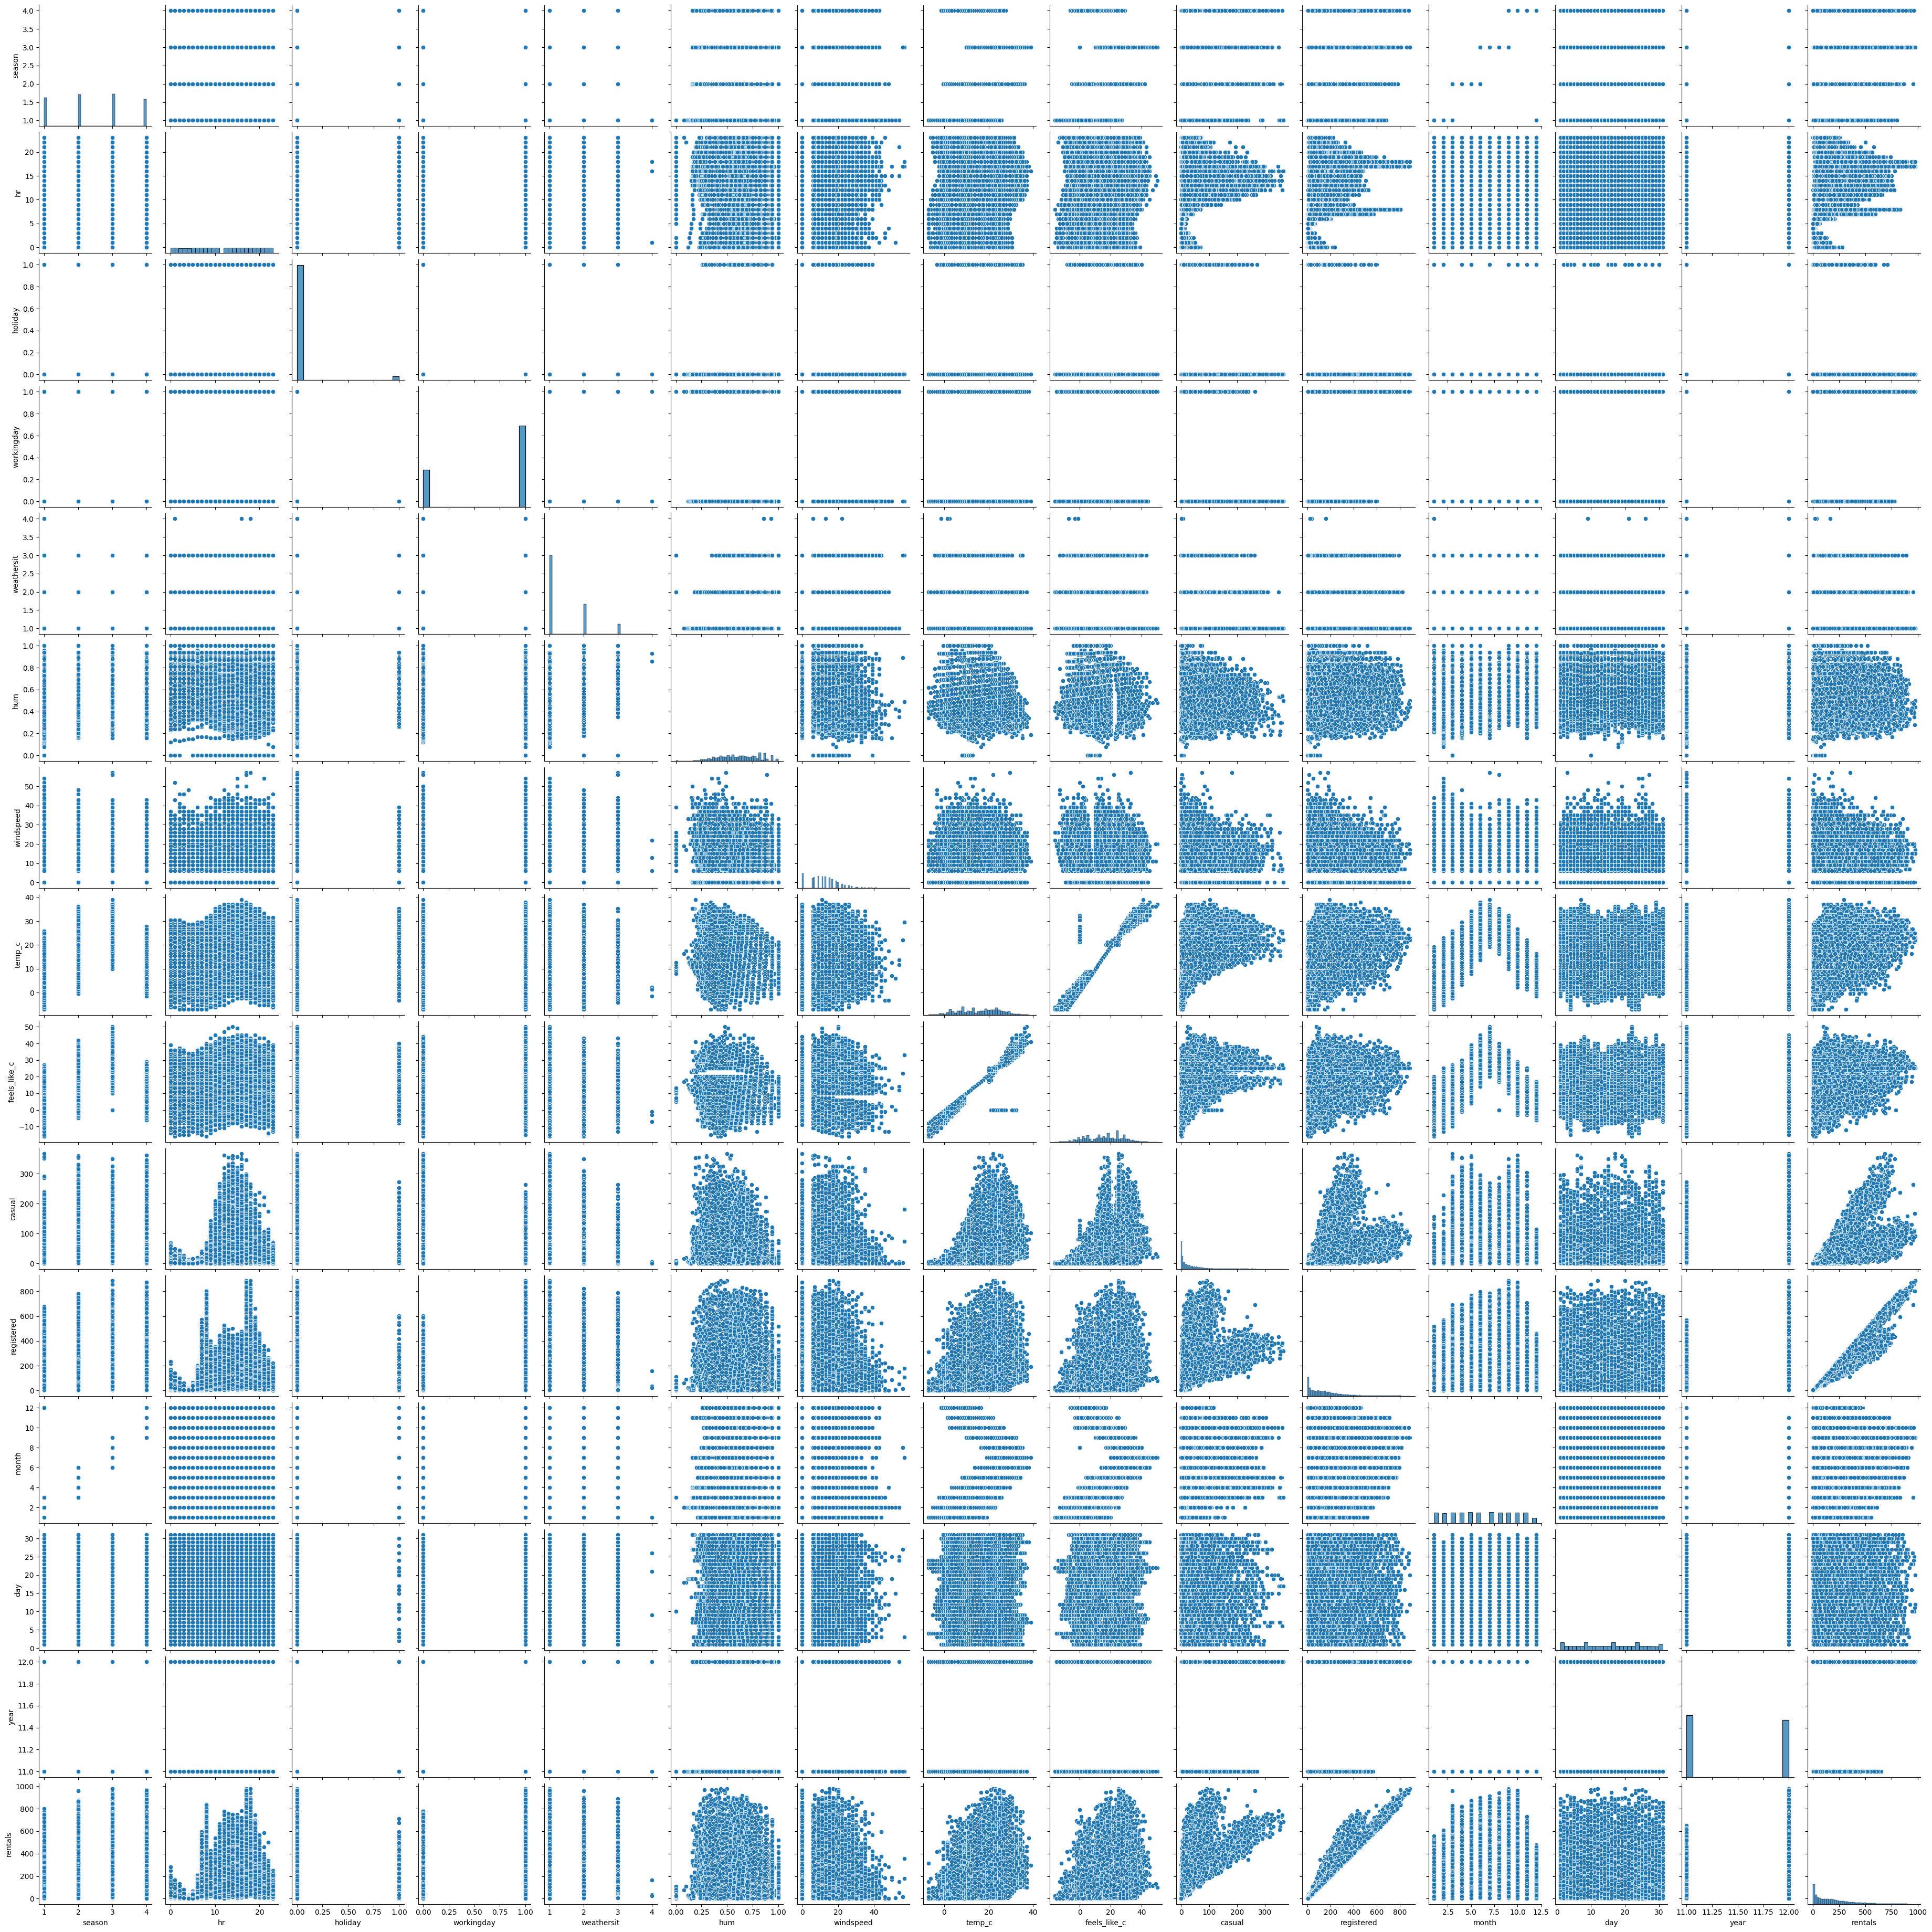

In [14]:
# visuals

# ['dteday', 'season', 'hr', 'holiday', 'workingday', 'weathersit', 'hum',
#        'windspeed', 'temp_c', 'feels_like_c', 'casual', 'registered', 'month',
#        'day', 'year', 'rentals']

sns.pairplot(main_df)

<AxesSubplot: xlabel='Season', ylabel='Temperature Outside (In Celsius)'>

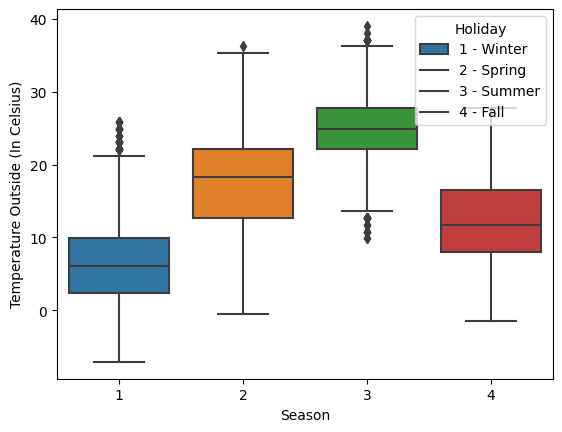

In [24]:
# USING
# plot = sns.scatterplot(main_df.groupby('rentals').sum(), x='windspeed', y='rentals')
# plot.set(xlabel='Combined Wind Speed (mph)', ylabel='Total Rentals')

# plot = sns.scatterplot(main_df, x='hr', y='registered')
# plot.set(xlabel='Hour Of Day', ylabel='Total Registered')

# plot = sns.barplot(main_df, x='hr', y='rentals')
# plot.set(xlabel='Hour Of Day', ylabel='Total Rentals')

# plot = sns.barplot(main_df, x='hr', y='casual')
# plot.set(xlabel='Hour Of Day', ylabel='Total Casuals')

# plot = sns.barplot(main_df, x='weathersit', y='registered')
# plot.set(xlabel='Weather Type', ylabel='Total Registered')
# plot.legend(title='Weather Types', loc='upper right', labels=['1 - Clear', '2 - Cloudy', '3 - Rainy/Snowy', '4 - Stormy'])

# plot = sns.barplot(main_df, x='holiday', y='rentals')
# plot.set(xlabel='Holiday', ylabel='Total Rentals')
# plot.legend(title='Holiday', loc='upper right', labels=['0 - No Holiday', '1 - Holiday'])

# plot = sns.lineplot(main_df, x='temp_c', y='rentals')
# plot.set(xlabel='Temperature Outside (In Celsius)', ylabel='Total Rentals')

# plot = sns.boxplot(main_df, x='season', y='temp_c')
# plot.set(xlabel='Season', ylabel='Temperature Outside (In Celsius)')
# plot.legend(title='Holiday', loc='upper right', labels=['1 - Winter', '2 - Spring', '3 - Summer', '4 - Fall'])

# plot
# sns.pairplot(main_df, diag_kind='kde')

In [3]:
test = [i.split('/') for i in mini_holdout_df['dteday']]
mini_holdout_df['month'] = [int(i[0]) for i in test]
mini_holdout_df['day']   = [int(i[1]) for i in test]
mini_holdout_df['year']  = [int(i[2]) for i in test]
mini_holdout_df = mini_holdout_df.drop(['dteday'], axis=1)

In [4]:
# main_encoded_df = pd.get_dummies(main_df)
test = [i.split('/') for i in main_df['dteday']]
main_df['month'] = [int(i[0]) for i in test]
main_df['day']   = [int(i[1]) for i in test]
main_df['year']  = [int(i[2]) for i in test]
main_df['rentals'] = main_df['registered'] + main_df['casual']

In [ ]:
main_df = main_df.drop(['registered', 'casual', 'dteday'], axis=1)

In [64]:
main_encoded_df = pd.get_dummies(main_df, columns=['hr'])
mini_holdout_encoded_df = pd.get_dummies(mini_holdout_df, columns=['hr'])

In [68]:
main_encoded_df.columns
mini_holdout_encoded_df.columns

Index(['season', 'holiday', 'workingday', 'weathersit', 'hum', 'windspeed',
       'temp_c', 'feels_like_c', 'month', 'day', 'year', 'hr_0', 'hr_1',
       'hr_2', 'hr_3', 'hr_4', 'hr_5', 'hr_6', 'hr_7', 'hr_8', 'hr_9', 'hr_10',
       'hr_11', 'hr_12', 'hr_13', 'hr_14', 'hr_15', 'hr_16', 'hr_17', 'hr_18',
       'hr_19', 'hr_20', 'hr_21', 'hr_22', 'hr_23'],
      dtype='object')

In [69]:
X = main_encoded_df.drop(['rentals'], axis=1)
# y = main_encoded_df[['rentals']]
y = main_encoded_df.copy()

# X_test, X_train, y_test, y_train = train_test_split(X, y, test_size=0.3, random_state=42)
X_test  = X[(X['day'] == 7) | (X['day'] == 14) | (X['day'] == 21)]
X_train = X[(X['day'] != 7) | (X['day'] != 14) | (X['day'] != 21)]
y_test  = y[(y['day'] == 7) | (y['day'] == 14) | (y['day'] == 21)]['rentals']
y_train = y[(y['day'] != 7) | (y['day'] != 21) | (y['day'] != 21)]['rentals']

In [70]:
# MODEL
Dropout, Dense = layers.Dropout, layers.Dense
mms = MinMaxScaler().fit(X_train)
X_train = mms.transform(X_train)
X_test = mms.transform(X_test)

In [66]:
model = Sequential()
model.add(Dense(128, input_dim=len(X_train[0]), activation='sigmoid'))
model.add(Dropout(.5))
model.add(Dense(256, activation='sigmoid'))
model.add(Dropout(.25))
model.add(Dense(32, activation='leaky_relu'))
model.add(Dense(1, activation='selu'))

2022-11-01 18:10:00.702011: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-01 18:10:00.762115: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-01 18:10:00.768729: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (mathidiot-G5-5587): /proc/driver/nvidia/version does not exist
2022-11-01 18:10:00.908399: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


NameError: name 'Dense' is not defined

In [72]:
# Compiling NN
opt = keras.optimizers.Adam()
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mse'])

In [73]:
# Training The NN
early_stop = keras.callbacks.EarlyStopping(monitor='val_mse', patience=30)
history = model.fit(X_train, y_train, epochs=2000, validation_split=.35, batch_size=60, callbacks=[early_stop],shuffle=False)

Epoch 1/2000
181/181 [==============================] - 2s 5ms/step - loss: 20928.7656 - mse: 20928.7656 - val_loss: 62261.6836 - val_mse: 62261.6836
Epoch 2/2000
181/181 [==============================] - 1s 3ms/step - loss: 19285.6211 - mse: 19285.6211 - val_loss: 57692.0273 - val_mse: 57692.0273
Epoch 3/2000
181/181 [==============================] - 1s 3ms/step - loss: 17998.7207 - mse: 17998.7207 - val_loss: 52232.4258 - val_mse: 52232.4258
Epoch 4/2000
181/181 [==============================] - 1s 3ms/step - loss: 16162.6807 - mse: 16162.6807 - val_loss: 47700.5625 - val_mse: 47700.5625
Epoch 5/2000
181/181 [==============================] - 1s 3ms/step - loss: 13417.6367 - mse: 13417.6367 - val_loss: 41549.6562 - val_mse: 41549.6562
Epoch 6/2000
181/181 [==============================] - 1s 4ms/step - loss: 11698.9365 - mse: 11698.9365 - val_loss: 39737.8320 - val_mse: 39737.8320
Epoch 7/2000
181/181 [==============================] - 1s 3ms/step - loss: 11054.8418 - mse: 11054.

In [74]:
hist = pd.DataFrame(history.history)
hist = hist.reset_index()
# hist

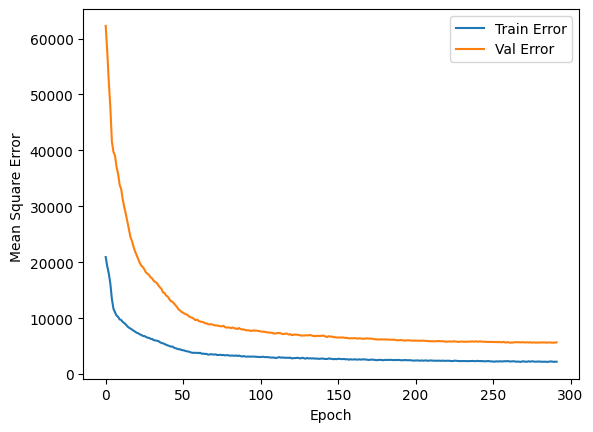

In [75]:
def plot_history():
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error ')
    plt.plot(hist['index'], hist['mse'], label='Train Error')
    plt.plot(hist['index'], hist['val_mse'], label = 'Val Error')
    plt.legend()
    # plt.ylim([0,50])

plot_history()

In [76]:
predictions = np.round(model.predict(X_test), 1)

52/52 [==============================] - 0s 1ms/step


In [77]:
mean_squared_error(y_test, predictions, squared=False)

59.41239597321784

In [78]:
r2_score(y_test, predictions)

0.8897662983301319

In [79]:
r2_score(y_test, predictions)

0.8897662983301319

In [82]:
predictions = np.round(model.predict(mini_holdout_encoded_df), 1)
pred = pd.DataFrame(predictions)
pred.to_csv('test-predictions.csv', index=False)

2/2 [==============================] - 0s 2ms/step
